# Image Captioning — Entrenamiento del Modelo con Atención

En este notebook se entrena un modelo de Image Captioning con atención visual.
El modelo aprende a generar descripciones en lenguaje natural a partir de imágenes,
enfocándose dinámicamente en distintas regiones visuales.

## Configuración del entorno

Se configuran los elementos necesarios para el entrenamiento del modelo:
- dispositivo de ejecución (CPU / GPU)
- carga de artefactos del preprocesado
- inicialización del modelo

In [10]:
import sys
sys.path.append("../src")

import dataset
print(dir(dataset))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append("../src")

from dataset import CaptionDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
import pickle

with open("../data/text_artifacts.pkl", "rb") as f:
    artifacts = pickle.load(f)

word2idx = artifacts["word2idx"]
idx2word = artifacts["idx2word"]
max_length = artifacts["max_length"]

vocab_size = len(word2idx)

print("Vocab size:", vocab_size)
print("Max length:", max_length)

Vocab size: 2960
Max length: 20


In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

# cargar captions procesadas
captions_df = pd.read_csv(
    "../data/captions_processed.txt",
    names=["image", "caption"]
)

# transforms (igual que antes)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Dataset (usa EXACTAMENTE el mismo que ya probaste)
dataset = CaptionDataset(
    captions_df=captions_df,
    images_path="../data/images_subset",
    word2idx=word2idx,
    max_length=max_length,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

In [4]:
images, captions = next(iter(dataloader))
print(images.shape)
print(captions.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 20])


## Modelo de Image Captioning con Atención

En esta sección se define el modelo de Image Captioning.
El modelo se compone de dos partes principales:

- Un encoder visual (CNN) que extrae características de la imagen
- Un decoder con atención (LSTM) que genera la descripción en texto

### Encoder visual

El encoder utiliza una CNN preentrenada para extraer características
espaciales de la imagen. Estas características se utilizarán por el
mecanismo de atención del decoder.

In [8]:
import torch
import torch.nn as nn
from torchvision import models

In [9]:
# ======================
# ENCODER (IMAGEN)
# ======================
class EncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # congelamos la CNN
        for param in resnet.parameters():
            param.requires_grad = False

        # quitamos la parte final de clasificación
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, images):
        features = self.resnet(images)          # (B, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1) # (B, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(-1))
        return features                         # (B, 49, 2048)

In [10]:
# ======================
# DECODER (TEXTO + ATENCIÓN)
# ======================
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, features, hidden):
        hidden = hidden.unsqueeze(1).repeat(1, features.size(1), 1)
        combined = torch.cat((features, hidden), dim=2)
        energy = torch.tanh(self.fc1(combined))
        scores = self.fc2(energy).squeeze(2)
        alpha = torch.softmax(scores, dim=1)
        context = (features * alpha.unsqueeze(2)).sum(dim=1)
        return context

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(feature_dim, hidden_size)
        self.lstm = nn.LSTMCell(embed_size + feature_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        batch_size = features.size(0)
        hidden = torch.zeros(batch_size, self.lstm.hidden_size).to(features.device)
        cell = torch.zeros(batch_size, self.lstm.hidden_size).to(features.device)

        embeddings = self.embedding(captions)
        outputs = []

        for t in range(embeddings.size(1)):
            context = self.attention(features, hidden)
            lstm_input = torch.cat((embeddings[:, t], context), dim=1)
            hidden, cell = self.lstm(lstm_input, (hidden, cell))
            outputs.append(self.fc(hidden))

        return torch.stack(outputs, dim=1)

In [13]:
# CREAMOS EL MODELO A CONTINUACIÓN:
embed_size = 256
hidden_size = 512
feature_dim = 2048

encoder = EncoderCNN().to(device)
decoder = DecoderRNN(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=len(word2idx),
    feature_dim=feature_dim
).to(device)

print("Modelo creado")

/Users/ariel/anaconda3/envs/MachineLearningUAX/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ariel/anaconda3/envs/MachineLearningUAX/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/ariel/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 64.3MB/s]


Modelo creado


In [14]:
images, captions = next(iter(dataloader))
images = images.to(device)
captions = captions.to(device)

features = encoder(images)
outputs = decoder(features, captions[:, :-1])

print("Features:", features.shape)
print("Outputs:", outputs.shape)


Features: torch.Size([32, 49, 2048])
Outputs: torch.Size([32, 19, 2960])


## Entrenamiento del modelo

Una vez verificado el forward pass, se procede al entrenamiento del modelo.
Durante el entrenamiento, el modelo aprende a predecir la siguiente palabra
dada una imagen y las palabras anteriores (teacher forcing).

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)

optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)

In [17]:
# Training Loop:
num_epochs = 3  # pocas épocas para empezar

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for images, captions in dataloader:
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()

        # Forward
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1])

        # Loss
        loss = criterion(
            outputs.reshape(-1, len(word2idx)),
            captions[:, 1:].reshape(-1)
        )

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/3] - Loss: 5.7535
Epoch [2/3] - Loss: 4.9103
Epoch [3/3] - Loss: 4.5766


## Resultados del entrenamiento

Tras entrenar el modelo durante 3 épocas, se observa una reducción progresiva
de la función de pérdida:

- Epoch 1: Loss ≈ 5.75
- Epoch 2: Loss ≈ 4.91
- Epoch 3: Loss ≈ 4.58

La disminución de la pérdida indica que el modelo está aprendiendo a asociar
características visuales con secuencias de palabras. Dado que el objetivo del
proyecto es demostrativo y orientado a portfolio, este nivel de entrenamiento
se considera suficiente.

## Generación de captions (inferencia)

Una vez entrenado el modelo, se procede a generar descripciones para imágenes
no vistas. En este proceso, el modelo genera la caption palabra a palabra,
utilizando las características visuales extraídas por el encoder.

In [18]:
idx2word = {idx: word for word, idx in word2idx.items()}

In [ ]:
def generate_caption(encoder, decoder, image, max_length=20):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        features = encoder(image)

        batch_size = features.size(0)
        hidden = torch.zeros(batch_size, decoder.lstm.hidden_size).to(image.device)
        cell = torch.zeros(batch_size, decoder.lstm.hidden_size).to(image.device)

        word = torch.tensor([word2idx["<start>"]]).to(image.device)
        caption = []

        for _ in range(max_length):
            embedding = decoder.embedding(word)
            context = decoder.attention(features, hidden)
            lstm_input = torch.cat((embedding.squeeze(1), context), dim=1)

            hidden, cell = decoder.lstm(lstm_input, (hidden, cell))
            output = decoder.fc(hidden)

            predicted_idx = output.argmax(1).item()
            predicted_word = idx2word[predicted_idx]

            if predicted_word == "<end>":
                break

            caption.append(predicted_word)
            word = torch.tensor([predicted_idx]).to(image.device)

    return " ".join(caption)

# Probemos con una imagen real 

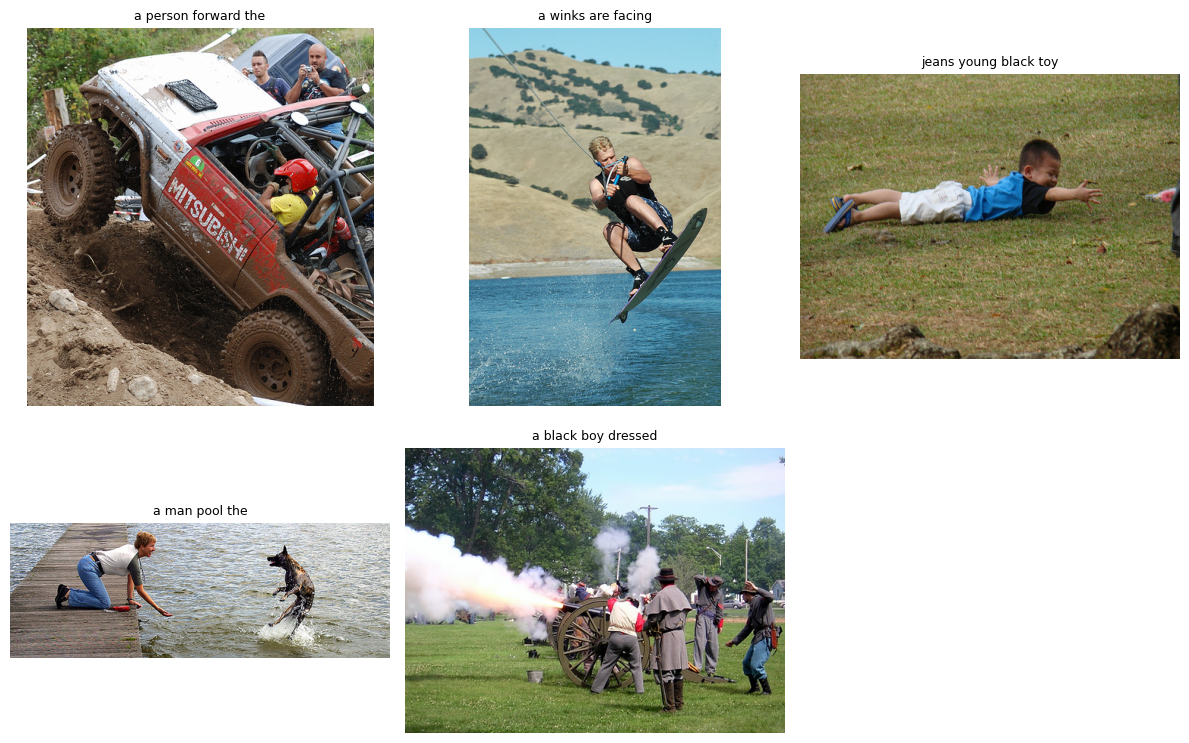

In [30]:
import random
import matplotlib.pyplot as plt
from PIL import Image

num_samples = 5
samples = captions_df.sample(num_samples)

plt.figure(figsize=(12, 8))

for i, (_, row) in enumerate(samples.iterrows()):
    image_path = os.path.join("../data/images_subset", row["image"])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    caption = generate_caption(encoder, decoder, image_tensor)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=9)

plt.tight_layout()
plt.show()